In [3]:
# Import necessary libraries
import string
from unidecode import unidecode
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity, cosine_distances
from sklearn.feature_extraction.text import TfidfVectorizer
from PIL import Image
import matplotlib.pyplot as plt
import os
import session_info

In [4]:
# Display session information
session_info.show(html=False)

-----
PIL                 10.3.0
matplotlib          3.8.4
numpy               1.26.4
pandas              2.2.2
session_info        1.0.0
sklearn             1.4.2
unidecode           NA
-----
IPython             8.25.0
jupyter_client      8.6.0
jupyter_core        5.7.2
jupyterlab          4.0.11
notebook            7.0.8
-----
Python 3.12.4 | packaged by Anaconda, Inc. | (main, Jun 18 2024, 15:03:56) [MSC v.1929 64 bit (AMD64)]
Windows-11-10.0.22631-SP0
-----
Session information updated at 2024-11-05 22:20


In [5]:
# Function to load and flatten images
def carregar_e_achatar_imagens(df, modo_cor='rgb', tamanho_imagem=(64, 64)):
    imagens = []
    ids = []
    for idx, row in df.iterrows():
        caminho_img = row['thumbnail_path']
        try:
            # Open the image from the specified path
            img = Image.open(caminho_img)
            # Resize the image to a standard size
            img = img.resize(tamanho_imagem)
            if modo_cor == 'grayscale':
                # Convert the image to grayscale
                img = img.convert('L')
                # Convert the image to a numpy array and flatten it
                img_array = np.array(img).flatten()
            else:
                # Ensure the image is in RGB mode
                img = img.convert('RGB')
                # Convert the image to a numpy array and flatten it
                img_array = np.array(img).flatten()
            # Add the image array to the list
            imagens.append(img_array)
            # Store the corresponding item_id
            ids.append(row['item_id'])
        except Exception as e:
            # Print error message if image cannot be loaded
            print(f"Error loading image {caminho_img}: {e}")
            continue
    # Return the numpy array of images and the list of ids
    return np.array(imagens), ids

In [6]:
# Function to clean and standardize text data
def clean_text(text: str) -> str:
    # Convert text to lowercase
    text = text.lower()
    # Remove accents
    text = unidecode(text)
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove digits
    text = ''.join([i for i in text if not i.isdigit()])
    # Strip whitespace
    text = text.strip()
    return text

In [7]:
# Load the dataset
sample_items_meli = pd.read_csv('C:\Datasets\sample_items_meli.csv')

<>:2: SyntaxWarning: invalid escape sequence '\D'
<>:2: SyntaxWarning: invalid escape sequence '\D'
C:\Users\David Luz\AppData\Local\Temp\ipykernel_11476\2182393695.py:2: SyntaxWarning: invalid escape sequence '\D'
  sample_items_meli = pd.read_csv('C:\Datasets\sample_items_meli.csv')


In [8]:
# Calculate the number of distinct categories
categorias_distintas = len(set(sample_items_meli['ITE_ITEM_DOM_DOMAIN_ID']))

In [9]:
# Remove domains with few orders using cumulative sum (threshold = 55%)
domain_vc = sample_items_meli.ITE_ITEM_DOM_DOMAIN_ID.value_counts().reset_index()
domain_vc.loc[:, "cum_sum"] = domain_vc.loc[:, "count"].cumsum()
domain_vc["%_acum"] = domain_vc.loc[:, "cum_sum"] / domain_vc.loc[:, "count"].sum()
domains_to_keep = domain_vc[domain_vc["%_acum"] <= 0.55]["ITE_ITEM_DOM_DOMAIN_ID"].values
sample_items_meli_mod = sample_items_meli[sample_items_meli.ITE_ITEM_DOM_DOMAIN_ID.isin(domains_to_keep)].reset_index(drop=True)

In [10]:
# Remove duplicate items from the dataset
sample_items_meli_mod = sample_items_meli_mod.drop_duplicates(subset='item_id')

In [11]:
# Clean the item titles
sample_items_meli_mod.loc[:, "clean_title"] = sample_items_meli_mod.loc[:, "ITE_ITEM_TITLE"].apply(clean_text)

# Split the data into train and test sets
# Train set: pool of items to generate similar items
# Test set: pool of items to use as seen by the buyer while browsing
train, test = train_test_split(sample_items_meli_mod,
                               test_size=0.1,
                               stratify=sample_items_meli_mod.ITE_ITEM_DOM_DOMAIN_ID,
                               random_state=42)
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

In [12]:
# -----------------------------
# Creating Image Embeddings
# -----------------------------

# TRAIN SET
# Load and flatten images in RGB mode
train_images, _ = carregar_e_achatar_imagens(train, modo_cor='rgb', tamanho_imagem=(120, 120))
# Standardize the image data
scaler = StandardScaler()
train_images_sc = scaler.fit_transform(train_images)
# Apply PCA to reduce dimensionality
pca = PCA(n_components=1000)
train_images_pca = pca.fit_transform(train_images_sc)

In [13]:
# TEST SET
# Load and flatten images in RGB mode
test_images, _ = carregar_e_achatar_imagens(test, modo_cor='rgb', tamanho_imagem=(120, 120))
# Standardize the image data using the same scaler
test_images_sc = scaler.transform(test_images)
# Apply PCA using the same model
test_images_pca = pca.transform(test_images_sc)

In [14]:
# -----------------------------
# Creating Text Embeddings
# -----------------------------

# TRAIN SET
# Create TF-IDF vectors for the cleaned titles
text_vec = TfidfVectorizer(max_features=5000)
tf_idf_train = text_vec.fit_transform(train.clean_title)
# Apply PCA to reduce dimensionality and sparsity
pca_text = PCA(n_components=500)
tf_idf_train_pca = pca_text.fit_transform(tf_idf_train.toarray())

In [15]:
# TEST SET
# Create TF-IDF vectors for the cleaned titles
tf_idf_test = text_vec.transform(test.clean_title)
# Apply PCA using the same model
tf_idf_test_pca = pca_text.transform(tf_idf_test.toarray())

In [16]:
# -----------------------------
# Comparing Aggregation Functions
# -----------------------------

# Function to compute Precision@k
def precision_at_k(test_indices, train_indices, sim_scores, k=5):
    precision_scores = []
    for idx in range(len(test_indices)):
        # Rank training items by similarity score
        top_k_indices = np.argsort(sim_scores[idx])[::-1][:k]
        # Count relevant items in top-k
        relevant_items = sum([1 for i in top_k_indices if train_indices[i] == test_indices[idx]])
        precision_scores.append(relevant_items / k)
    return np.mean(precision_scores), precision_scores

# Function to compute Diversity@k
def diversity_at_k(sim_scores, train_embeddings, k=5):
    diversities = []
    for idx in range(len(sim_scores)):
        # Get indices of top-k most similar items
        top_k_indices = np.argsort(sim_scores[idx])[::-1][:k]
        # Extract embeddings of the top-k items
        top_k_embeddings = train_embeddings[top_k_indices]
        # Compute pairwise distances among top-k items
        pairwise_distances = cosine_distances(top_k_embeddings)
        # Compute mean of distances, excluding self-distances
        diversity_score = np.mean(pairwise_distances[np.triu_indices(k, k=1)])
        diversities.append(diversity_score)
    return np.mean(diversities)

In [17]:
# Initialize lists to store similarity scores for each test item
all_sim_scores_weighted_avg = []
all_sim_scores_max = []
all_sim_scores_exponential = []
all_sim_scores_text_only = []
all_sim_scores_img_only = []

# Define weights for text and image similarities
alpha = 0.7  # Weight for text similarity
beta = 1 - alpha  # Weight for image similarity

# Compute similarity scores using different aggregation methods
for idx in range(len(test_images_pca)):
    # Compute cosine similarity for images and texts
    cos_sim_img = cosine_similarity(test_images_pca[idx].reshape(1, -1), train_images_pca)
    cos_sim_text = cosine_similarity(tf_idf_test_pca[idx].reshape(1, -1), tf_idf_train_pca)

    # Aggregation strategies
    sim_scores_weighted_avg = alpha * cos_sim_text + beta * cos_sim_img
    sim_scores_max = np.maximum(alpha * cos_sim_text, beta * cos_sim_img)
    sim_scores_exponential = np.exp(alpha * cos_sim_text) * (beta * cos_sim_img)

    # Store the similarity scores
    all_sim_scores_weighted_avg.append(sim_scores_weighted_avg.flatten())
    all_sim_scores_max.append(sim_scores_max.flatten())
    all_sim_scores_exponential.append(sim_scores_exponential.flatten())
    all_sim_scores_text_only.append(cos_sim_text.flatten())
    all_sim_scores_img_only.append(cos_sim_img.flatten())

# Convert lists to numpy arrays
sim_scores_weighted_avg = np.vstack(all_sim_scores_weighted_avg)
sim_scores_max = np.vstack(all_sim_scores_max)
sim_scores_exponential = np.vstack(all_sim_scores_exponential)
sim_scores_text_only = np.vstack(all_sim_scores_text_only)
sim_scores_img_only = np.vstack(all_sim_scores_img_only)


In [18]:
# Create a dictionary of aggregation methods
aggregation_methods = {
    'Weighted Average': sim_scores_weighted_avg,
    'Max of Weighted Similarities': sim_scores_max,
    'Exponential Weighting': sim_scores_exponential,
    'Text Only': sim_scores_text_only,
    'Image Only': sim_scores_img_only
}

In [19]:
# Define test and train indices for relevant items
test_indices = test['ITE_ITEM_DOM_DOMAIN_ID'].values
train_indices = train['ITE_ITEM_DOM_DOMAIN_ID'].values

In [20]:
# Function to evaluate aggregation methods
def evaluate_aggregation_methods(aggregation_methods, test_indices, train_indices, k=5):
    results = {}
    for method_name, sim_scores in aggregation_methods.items():
        precision, precision_scores = precision_at_k(test_indices, train_indices, sim_scores, k=k)
        diversity = diversity_at_k(sim_scores, train_images_pca, k=k)
        results[method_name] = {
            'Precision': precision,
            'Diversity': diversity
        }
        print(f"{method_name} - Precision@{k}: {precision}, Diversity@{k}: {diversity}")
    return results

Weighted Average - Precision@5: 0.8187327823691458, Diversity@5: 0.6219346694176545
Max of Weighted Similarities - Precision@5: 0.8286501377410469, Diversity@5: 0.8107635519660875
Exponential Weighting - Precision@5: 0.6077134986225895, Diversity@5: 0.3732083116989487
Text Only - Precision@5: 0.8280991735537191, Diversity@5: 0.811244083896417
Image Only - Precision@5: 0.33719008264462813, Diversity@5: 0.32186047639974735

Top-5 recommendations for Test Case 3


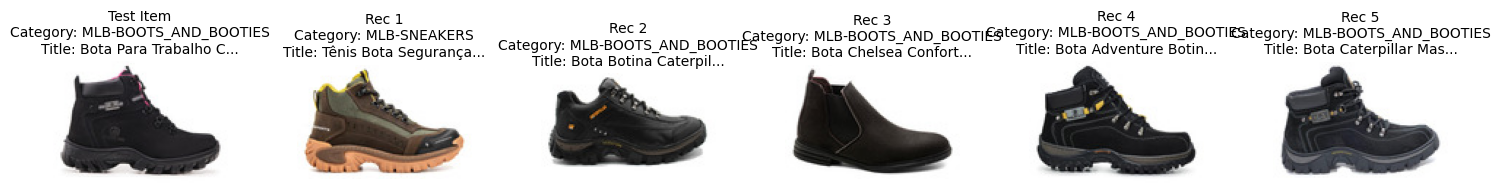


Top-5 recommendations for Test Case 4


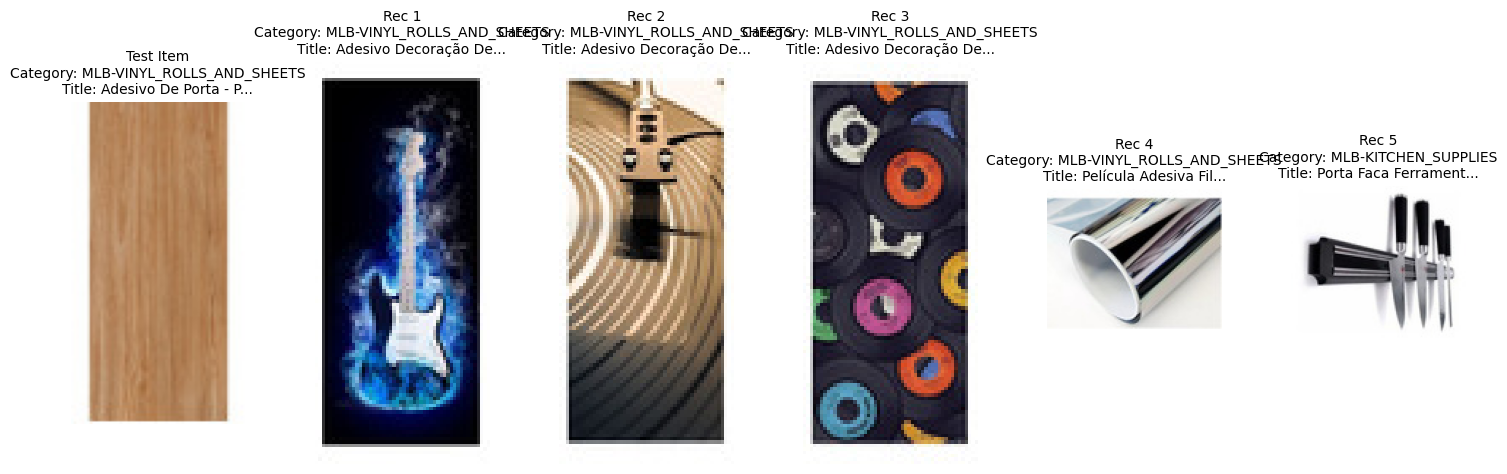


Top-5 recommendations for Test Case 5


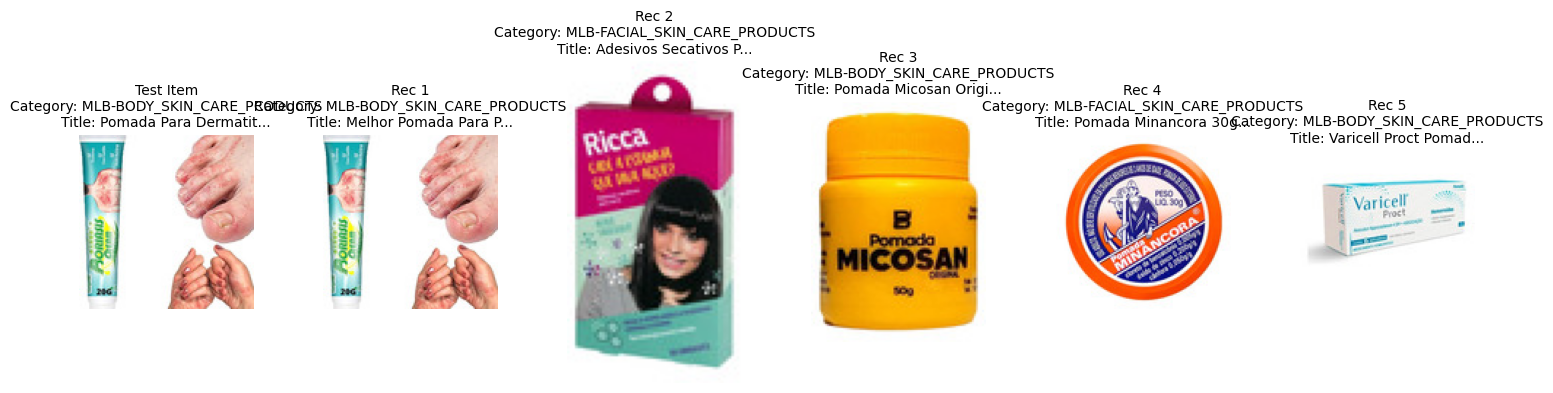

In [21]:
# Evaluate the aggregation methods
evaluation_results = evaluate_aggregation_methods(aggregation_methods, test_indices, train_indices, k=5)

# Display the evaluation results in a DataFrame
pd.DataFrame(evaluation_results)

# -----------------------------
# Plotting Test Products and Recommendations
# -----------------------------

# Set the value of k
k = 5
sim_scores = sim_scores_text_only
# Function to plot a test item with its top-k recommendations
def plot_top_k_examples(test_idx, k=5):
    # Get the test item and its details
    test_item = test.iloc[test_idx]
    test_category = test_item['ITE_ITEM_DOM_DOMAIN_ID']
    test_image_path = test_item['thumbnail_path']
    test_title = test_item['ITE_ITEM_TITLE']

    # Compute indices of top-k recommendations
    top_k_indices = np.argsort(sim_scores[test_idx])[::-1][:k]

    # Create a subplot for the test item and recommendations
    fig, axs = plt.subplots(1, k+1, figsize=(18, 6))

    # Plot the test item
    axs[0].imshow(plt.imread(test_image_path))
    axs[0].set_title(f"Test Item\nCategory: {test_category}\nTitle: {test_title[:20]}...", fontsize=10)
    axs[0].axis('off')

    # Plot the top-k recommendations
    for i, idx in enumerate(top_k_indices):
        recommended_item = train.iloc[idx]
        recommended_category = recommended_item['ITE_ITEM_DOM_DOMAIN_ID']
        recommended_image_path = recommended_item['thumbnail_path']
        recommended_title = recommended_item['ITE_ITEM_TITLE']

        axs[i+1].imshow(plt.imread(recommended_image_path))
        axs[i+1].set_title(f"Rec {i+1}\nCategory: {recommended_category}\nTitle: {recommended_title[:20]}...", fontsize=10)
        axs[i+1].axis('off')

    # Adjust spacing between subplots
    plt.subplots_adjust(wspace=0.4)
    plt.show()

# Plot recommendations for specific test indices
for test_idx in [3, 4, 5]:
    print(f"\nTop-{k} recommendations for Test Case {test_idx}")
    plot_top_k_examples(test_idx, k=k)

# Repeat the plotting with a different similarity score
sim_scores = sim_scores_max

# Function to plot a test item with its top-k recommendations
def plot_top_k_examples(test_idx, k=5):
    # Get the test item and its details
    test_item = test.iloc[test_idx]
    test_category = test_item['ITE_ITEM_DOM_DOMAIN_ID']
    test_image_path = test_item['thumbnail_path']
    test_title = test_item['ITE_ITEM_TITLE']

    # Compute indices of top-k recommendations
    top_k_indices = np.argsort(sim_scores[test_idx])[::-1][:k]

    # Create a subplot for the test item and recommendations
    fig, axs = plt.subplots(1, k+1, figsize=(18, 6))

    # Plot the test item
    axs[0].imshow(plt.imread(test_image_path))
    axs[0].set_title(f"Test Item\nCategory: {test_category}\nTitle: {test_title[:20]}...", fontsize=10)
    axs[0].axis('off')

    # Plot the top-k recommendations
    for i, idx in enumerate(top_k_indices):
        recommended_item = train.iloc[idx]
        recommended_category = recommended_item['ITE_ITEM_DOM_DOMAIN_ID']
        recommended_image_path = recommended_item['thumbnail_path']
        recommended_title = recommended_item['ITE_ITEM_TITLE']

        axs[i+1].imshow(plt.imread(recommended_image_path))
        axs[i+1].set_title(f"Rec {i+1}\nCategory: {recommended_category}\nTitle: {recommended_title[:20]}...", fontsize=10)
        axs[i+1].axis('off')

    # Adjust spacing between subplots
    plt.subplots_adjust(wspace=0.4)
    plt.show()


Top-5 recommendations for Test Case 3


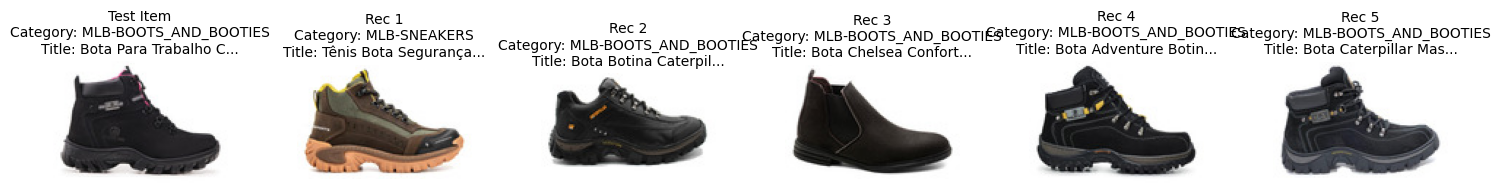


Top-5 recommendations for Test Case 4


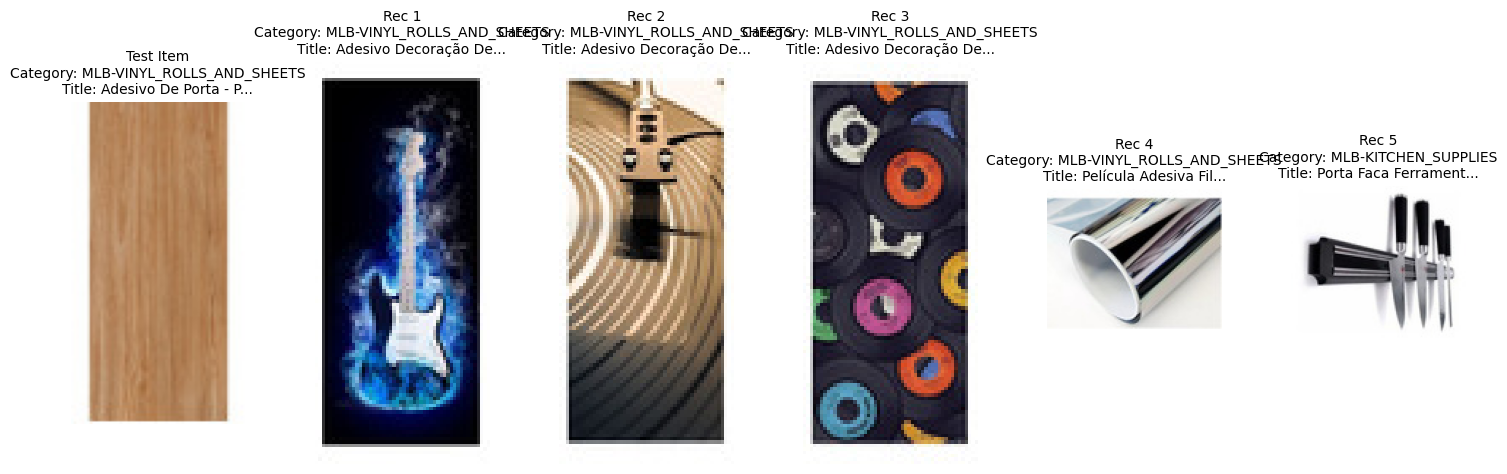


Top-5 recommendations for Test Case 5


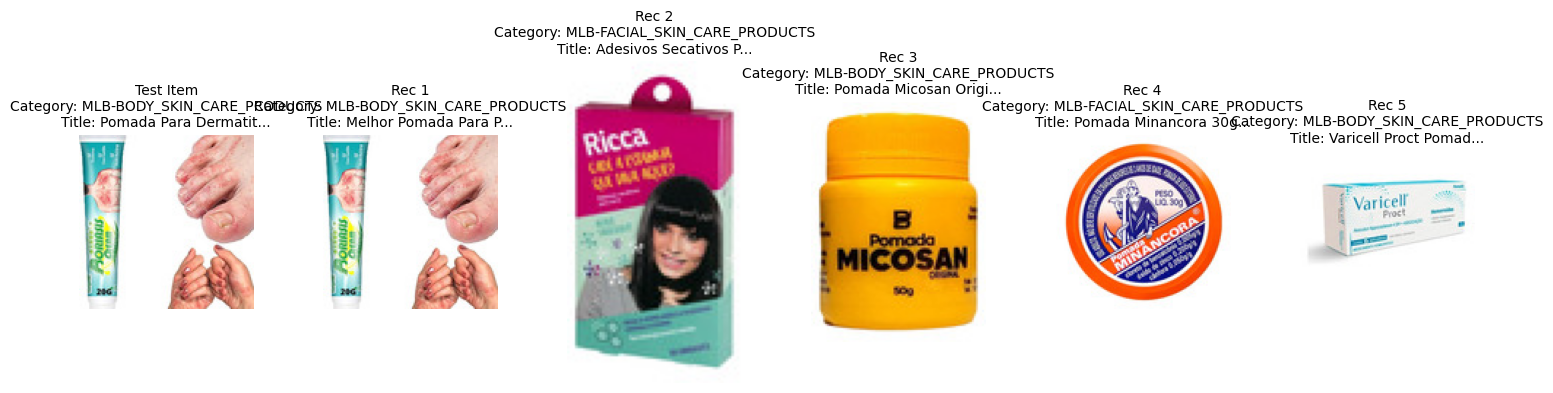

In [22]:
# Plot recommendations for specific test indices
for test_idx in [3, 4, 5]:
    print(f"\nTop-{k} recommendations for Test Case {test_idx}")
    plot_top_k_examples(test_idx, k=k)

In [23]:
# -----------------------------
# Optimize PCA Components for Image Embeddings
# -----------------------------
n_components_list = [100, 500, 1000, 1500]
k = 5  # Top-k recommendations

# Initialize lists to store evaluation metrics
precision_scores_image_pca = []
diversity_scores_image_pca = []

for n_components in n_components_list:
    print(f"\nEvaluating Image PCA with n_components = {n_components}")
    # Recompute PCA for images with n_components
    pca_image = PCA(n_components=n_components)
    train_images_pca = pca_image.fit_transform(train_images_sc)
    test_images_pca = pca_image.transform(test_images_sc)
    
    # Use existing text embeddings
    # Compute similarity scores using Weighted Average with alpha = 0.7
    alpha = 0.7
    beta = 1 - alpha
    all_sim_scores = []
    
    for idx in range(len(test_images_pca)):
        cos_sim_img = cosine_similarity(test_images_pca[idx].reshape(1, -1), train_images_pca)
        cos_sim_text = cosine_similarity(tf_idf_test_pca[idx].reshape(1, -1), tf_idf_train_pca)
        sim_scores = alpha * cos_sim_text + beta * cos_sim_img
        all_sim_scores.append(sim_scores.flatten())
    
    sim_scores_pca = np.vstack(all_sim_scores)
    
    # Evaluate the model
    precision, _ = precision_at_k(test_indices, train_indices, sim_scores_pca, k=k)
    diversity = diversity_at_k(sim_scores_pca, train_images_pca, k=k)
    
    # Store results
    precision_scores_image_pca.append(precision)
    diversity_scores_image_pca.append(diversity)
    
    print(f"Precision@{k}: {precision:.4f}, Diversity@{k}: {diversity:.4f}")



Evaluating Image PCA with n_components = 100
Precision@5: 0.8160, Diversity@5: 0.5521

Evaluating Image PCA with n_components = 500
Precision@5: 0.8193, Diversity@5: 0.6060

Evaluating Image PCA with n_components = 1000
Precision@5: 0.8185, Diversity@5: 0.6219

Evaluating Image PCA with n_components = 1500
Precision@5: 0.8182, Diversity@5: 0.6304


Accuracy:
Accuracy increases slightly from 0.8160 to 0.8193 when moving from 100 to 500 components.
Beyond 500 components, accuracy remains practically stable, with very little variation.

Diversity:
Diversity increases consistently with the number of components, rising from 0.5521 (100 components) to 0.6304 (1500 components).

Optimal Balance: Using around 500 components for images appears to be an optimal point, where accuracy reaches its peak and begins to stabilize.

Marginal Gains: Increasing the number of components beyond 500 does not result in significant improvements in accuracy but continues to gradually enhance diversity.

Complexity Consideration: More components increase computational complexity without substantial benefits in accuracy.

In [24]:
# -----------------------------
# Optimize PCA Components for Text Embeddings
# -----------------------------
n_components_list = [100, 300, 500, 700]
k = 5  # Top-k recommendations

# Initialize lists to store evaluation metrics
precision_scores_text_pca = []
diversity_scores_text_pca = []

for n_components in n_components_list:
    print(f"\nEvaluating Text PCA with n_components = {n_components}")
    # Recompute PCA for text with n_components
    pca_text = PCA(n_components=n_components)
    tf_idf_train_pca = pca_text.fit_transform(tf_idf_train.toarray())
    tf_idf_test_pca = pca_text.transform(tf_idf_test.toarray())
    
    # Use existing image embeddings
    # Compute similarity scores using Weighted Average with alpha = 0.7
    alpha = 0.7
    beta = 1 - alpha
    all_sim_scores = []
    
    for idx in range(len(test_images_pca)):
        cos_sim_img = cosine_similarity(test_images_pca[idx].reshape(1, -1), train_images_pca)
        cos_sim_text = cosine_similarity(tf_idf_test_pca[idx].reshape(1, -1), tf_idf_train_pca)
        sim_scores = alpha * cos_sim_text + beta * cos_sim_img
        all_sim_scores.append(sim_scores.flatten())
    
    sim_scores_pca = np.vstack(all_sim_scores)
    
    # Evaluate the model
    precision, _ = precision_at_k(test_indices, train_indices, sim_scores_pca, k=k)
    diversity = diversity_at_k(sim_scores_pca, train_images_pca, k=k)
    
    # Store results
    precision_scores_text_pca.append(precision)
    diversity_scores_text_pca.append(diversity)
    
    print(f"Precision@{k}: {precision:.4f}, Diversity@{k}: {diversity:.4f}")



Evaluating Text PCA with n_components = 100
Precision@5: 0.7923, Diversity@5: 0.5964

Evaluating Text PCA with n_components = 300
Precision@5: 0.8116, Diversity@5: 0.6230

Evaluating Text PCA with n_components = 500
Precision@5: 0.8179, Diversity@5: 0.6279

Evaluating Text PCA with n_components = 700
Precision@5: 0.8168, Diversity@5: 0.6364


Accuracy:
Accuracy increases significantly from 0.7923 to 0.8116 when moving from 100 to 300 components.
From 500 components onward, accuracy stabilizes around 0.8179.

Diversity:
Diversity also increases with the number of components, but the gains diminish after 500 components.

Conclusion for Texts:

Optimal Balance: 500 components for texts appear sufficient to capture most of the relevant information.

Diminishing Returns: Adding more than 500 components results in minimal gains in both accuracy and diversity.

Computational Efficiency: Maintaining 500 components strikes a good balance among accuracy, diversity, and computational efficiency.

General Conclusions:
Point of Diminishing Returns:
For both images and texts, there is a point (approximately at 500 components) where gains in accuracy begin to stabilize.

Balance Between Accuracy and Diversity:
Accuracy reaches a plateau after a certain point, while diversity continues to increase, though with smaller increments.
It's important to balance the need for high accuracy with the diversity of recommendations.

Recommendation:
Choosing 500 components for both images and texts appears to be a balanced choice.
This configuration maximizes accuracy without unnecessarily increasing complexity and still provides good diversity.

Computational Complexity:
Increasing the number of components raises the data dimensionality and, consequently, the processing time.
Since gains in accuracy are minimal beyond 500 components, it's not computationally efficient to continue increasing this number.

Alpha: 0.00, Precision@5: 0.3355, Diversity@5: 0.3269
Alpha: 0.10, Precision@5: 0.4251, Diversity@5: 0.3298
Alpha: 0.20, Precision@5: 0.5317, Diversity@5: 0.3486
Alpha: 0.30, Precision@5: 0.6380, Diversity@5: 0.3880
Alpha: 0.40, Precision@5: 0.7273, Diversity@5: 0.4426
Alpha: 0.50, Precision@5: 0.7857, Diversity@5: 0.5038
Alpha: 0.60, Precision@5: 0.8061, Diversity@5: 0.5654
Alpha: 0.70, Precision@5: 0.8168, Diversity@5: 0.6364
Alpha: 0.80, Precision@5: 0.8223, Diversity@5: 0.6975
Alpha: 0.90, Precision@5: 0.8242, Diversity@5: 0.7629
Alpha: 1.00, Precision@5: 0.8201, Diversity@5: 0.8108


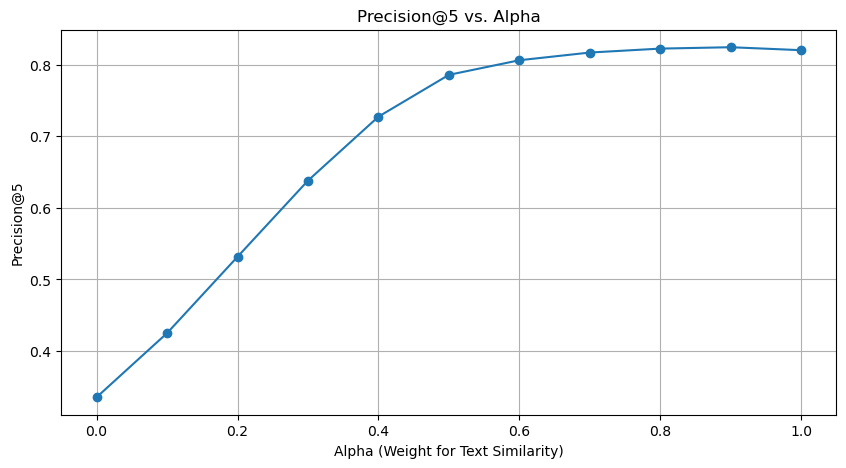

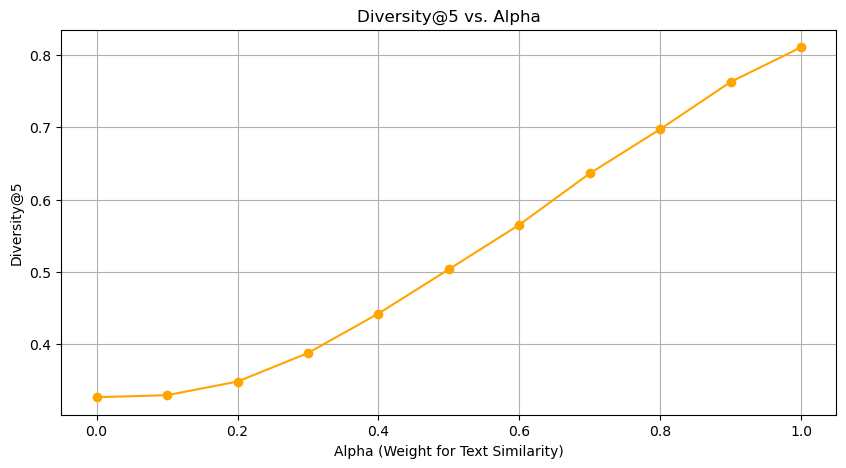

In [25]:
# -----------------------------
# Parameter Sensitivity Analysis of Alpha and Beta
# -----------------------------
import matplotlib.pyplot as plt

# Define the range of alpha values to test
alpha_values = np.linspace(0, 1, 11)  # 0.0, 0.1, ..., 1.0
k = 5  # Top-k recommendations

# Initialize lists to store evaluation metrics
precision_scores_alpha = []
diversity_scores_alpha = []

# Loop over alpha values
for alpha in alpha_values:
    beta = 1 - alpha
    all_sim_scores = []

    # Compute aggregated similarity scores for each test item
    for idx in range(len(test_images_pca)):
        # Compute cosine similarities
        cos_sim_img = cosine_similarity(test_images_pca[idx].reshape(1, -1), train_images_pca)
        cos_sim_text = cosine_similarity(tf_idf_test_pca[idx].reshape(1, -1), tf_idf_train_pca)

        # Aggregate similarities using current alpha and beta
        sim_scores = alpha * cos_sim_text + beta * cos_sim_img
        all_sim_scores.append(sim_scores.flatten())

    # Stack similarity scores
    sim_scores_alpha = np.vstack(all_sim_scores)

    # Evaluate using Precision@k and Diversity@k
    precision, _ = precision_at_k(test_indices, train_indices, sim_scores_alpha, k=k)
    diversity = diversity_at_k(sim_scores_alpha, train_images_pca, k=k)

    # Store the results
    precision_scores_alpha.append(precision)
    diversity_scores_alpha.append(diversity)

    print(f"Alpha: {alpha:.2f}, Precision@{k}: {precision:.4f}, Diversity@{k}: {diversity:.4f}")

# Plot Precision@k vs. Alpha
plt.figure(figsize=(10, 5))
plt.plot(alpha_values, precision_scores_alpha, marker='o')
plt.title(f'Precision@{k} vs. Alpha')
plt.xlabel('Alpha (Weight for Text Similarity)')
plt.ylabel(f'Precision@{k}')
plt.grid(True)
plt.show()

# Plot Diversity@k vs. Alpha
plt.figure(figsize=(10, 5))
plt.plot(alpha_values, diversity_scores_alpha, marker='o', color='orange')
plt.title(f'Diversity@{k} vs. Alpha')
plt.xlabel('Alpha (Weight for Text Similarity)')
plt.ylabel(f'Diversity@{k}')
plt.grid(True)
plt.show()


Analysis of Results with Varying Alpha Values:

As the Alpha value increases from 0.00 to 1.00, both Precision@5 and Diversity@5 tend to improve, but with distinct behaviors across different Alpha ranges.

Range of Significant Increase in Precision and Diversity (Alpha between 0.00 and 0.50):
Sharp Growth:
Initially, moving from Alpha = 0.00 (image similarity only) to Alpha = 0.50 yields a substantial increase in both Precision@5 and Diversity@5.

Precision@5: Jumps from 0.3355 to 0.7857.
Diversity@5: Rises from 0.3269 to 0.5038.
Interpretation:
Low to intermediate Alpha values allow for rapid gains in both precision and diversity, suggesting that incorporating text similarity significantly enhances the recommendation system.
Range of Diminishing Returns in Precision (Alpha between 0.50 and 0.90):
Modest Gains:
From Alpha = 0.50 onward, Precision@5 continues to grow but with smaller increments.

Precision@5: Increases from 0.7857 (Alpha = 0.50) to 0.8242 (Alpha = 0.90).
Saturation Point:
Precision growth begins to stabilize, suggesting a saturation point around Alpha = 0.90.
Interpretation:
In this range, text similarity predominates, and adding more weight to text yields marginal gains in precision.
Diminishing Returns and Stabilization in Diversity (Alpha between 0.60 and 1.00):
Gradual Growth:
Diversity@5 continues to increase up to Alpha = 1.00, but the growth rate diminishes after Alpha = 0.80.

Diversity@5: Reaches 0.8108 at Alpha = 1.00.
Interpretation:
Diversity continues to improve with rising Alpha values, but the gains become progressively smaller, indicating stabilization near the maximum Alpha value.
Conclusion on the Optimal Point:
Ideal Alpha between 0.80 and 0.90:
A balance between precision and diversity appears to be achieved around Alpha = 0.80 to 0.90.

Precision@5: Close to maximum value (0.8242 at Alpha = 0.90).
Diversity@5: High, without sacrificing precision.
Slight Decrease at Alpha = 1.00:
At Alpha = 1.00 (text similarity only), Precision@5 slightly decreases to 0.8201, suggesting that the image similarity contribution, though smaller, remains beneficial.
Recommendation:
Setting Alpha between 0.80 and 0.90 is recommended to maximize precision without sacrificing diversity.
This range optimally leverages textual information while maintaining a complementary contribution from image similarity.
General Interpretation:
Importance of Text Similarity:
Text is the main source of information for recommendations, significantly enhancing both precision and diversity.
Contribution of Image Similarity:
Though less impactful, image similarity adds value to the system by complementing textual information.
Small weights for image similarity (Beta between 0.20 and 0.10) can slightly improve both precision and diversity.
Precision-Diversity Trade-off:
Increasing Alpha improves both metrics up to a point, after which gains become marginal.
It's important to balance weights to avoid overemphasizing one modality at the expense of the other.

 Implications:
Parameter Adjustment:
Set Alpha between 0.80 and 0.90 with a corresponding Beta between 0.20 and 0.10 for optimal performance.
Future Improvements:
Invest in advanced natural language processing techniques to enhance text representations.
Explore additional similarity-combination methods to capture more complex interactions between text and image.
Additional Evaluation:
Conduct tests with intermediate Alpha values (e.g., 0.85) to further refine the optimal point.
Analyze the impact of these adjustments across different product categories to verify consistency of results.